In [38]:
%load_ext autoreload
%autoreload 2

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import numpy as np
import scipy

from tqdm import tqdm 

import os

import matplotlib.pyplot as plt
from neurorient import NeurOrient
from neurorient.utils_visualization import save_mrc, display_volumes, display_fsc
from neurorient.reconstruction.phasing import PhaseRetriever
from neurorient.metrics import compute_fsc, align_rotation_matrices
from neurorient.reconstruction.slicing import real_mesh_2_reciprocal_mesh

from sklearn.model_selection import train_test_split

import h5py
from pytorch3d.transforms import matrix_to_quaternion, quaternion_to_matrix, so3_rotation_angle, so3_relative_angle

device = 'cuda' if torch.cuda.is_available() else 'cpu'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
pdb = '1BXR'
poisson = True
num_images = 10000
increase_factor = 10

In [3]:
spi_data = torch.load(f'/pscratch/sd/z/zhantao/neurorient_repo/data/{pdb}_increase{increase_factor:d}_poisson{poisson}_num{num_images//1000:d}K.pt')
ckpt_path = '/pscratch/sd/z/zhantao/neurorient_repo/model/lightning_logs/version_15635334/checkpoints/last.ckpt'
save_dir = '/pscratch/sd/z/zhantao/neurorient_repo/data'
print(spi_data.keys())

dict_keys(['orientations', 'intensities', 'pixel_position_reciprocal', 'pixel_index_map', 'volume', 'img_real_mesh', 'vol_real_mesh', 'time_stamp'])


In [4]:
model = NeurOrient.load_from_checkpoint(ckpt_path)

In [5]:
model.to(device)

grid_reciprocal = np.pi * model.grid_position_reciprocal / model.grid_position_reciprocal.max()
with torch.no_grad():
    intensity = model.predict_intensity(grid_reciprocal.to(device))
intensity_pred = (torch.exp(intensity) - 1).cpu().numpy() / model.loss_scale_factor

In [6]:
model.grid_position_reciprocal.shape

torch.Size([128, 128, 128, 3])

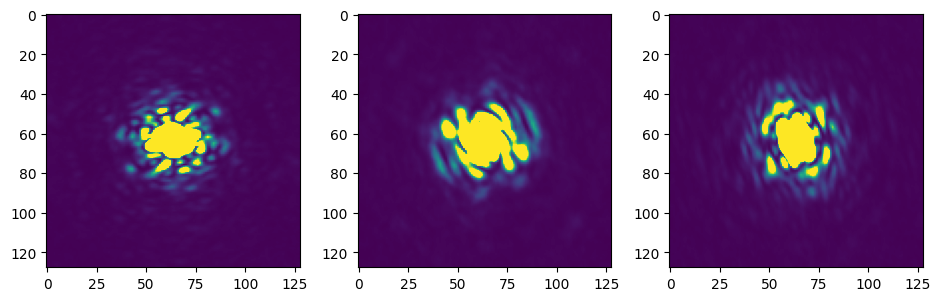

In [7]:
display_volumes(intensity_pred, closefig=False, vmin=0, vmax=1e-3 * intensity_pred.max())

In [8]:
phase_retriever = PhaseRetriever(n_phase_loops=10, beta_HIO=0.3, beta_DM=0.3, shrink_wrap_method='max')
rho_phased, support_phased = phase_retriever.phase(torch.from_numpy(intensity_pred.clip(intensity_pred.max() * 1e-5)).sqrt().to(device))

Phase Retrieval:   0%|          | 0/10 [00:00<?, ?it/s]

/pscratch/sd/z/zhantao/conda/om/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Phase Retrieval: 100%|██████████| 10/10 [00:01<00:00,  7.73it/s]


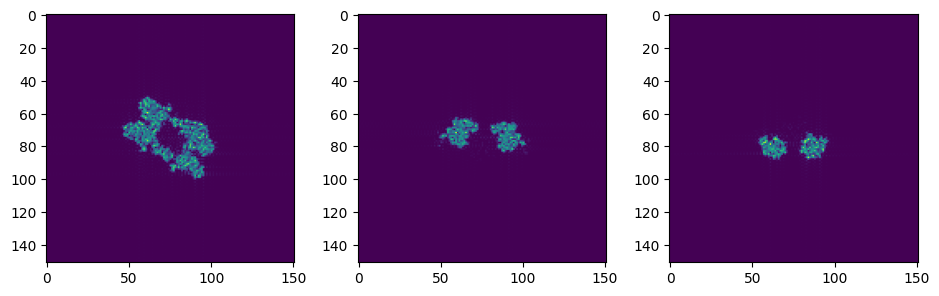

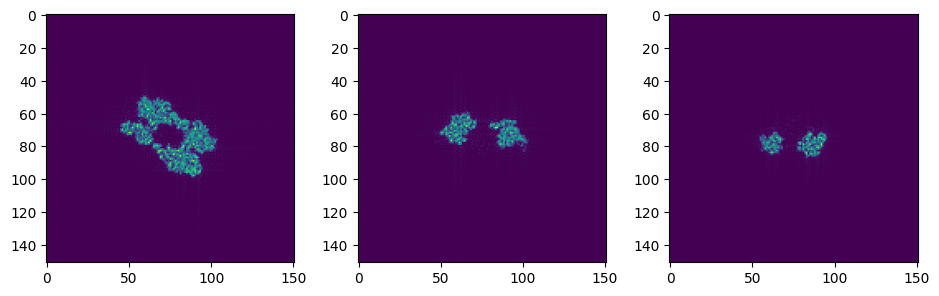

In [9]:
from neurorient.reconstruction.phasing import recenter

real_volume = torch.fft.fftshift(torch.fft.ifftn(torch.fft.ifftshift(spi_data['volume'])).real).clamp(0.)
display_volumes(real_volume, closefig=False)
real_volume = torch.fft.fftshift(recenter(
    torch.fft.ifftshift(real_volume), torch.ones_like(real_volume), M=real_volume.shape[-1]
)[0])
display_volumes(real_volume, closefig=False)

Initial CC between unzoomed / unfiltered volumes is: 0.340
Alignment CC after rotation is: 0.840
Final CC between unzoomed / unfiltered volumes is: 0.823
Estimated resolution from FSC: 23.7 Angstrom


/global/u2/z/zhantao/Projects/NeuralOrientationMatching/neurorient/utils_visualization.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  ax2.set_xticklabels([f"{1/q:.2f}" for q in ax1.get_xticks()])


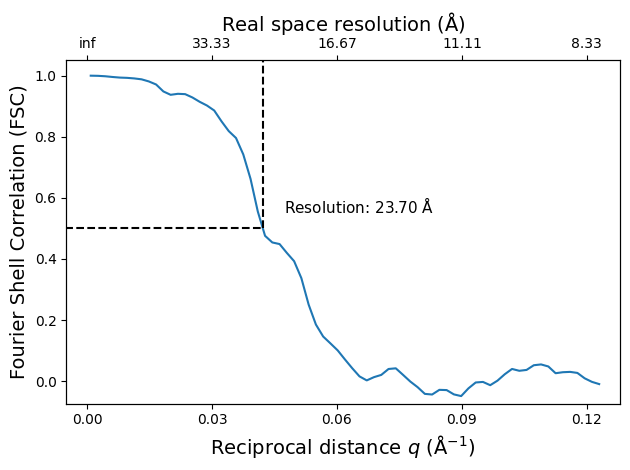

In [10]:
rho_cc, qshell, fsc = compute_fsc(
    real_volume, 
    spi_data['vol_real_mesh'], 
    rho_phased,
    model.grid_position_real,
    volume_type='electron_density')

display_fsc(qshell, fsc, resolution=rho_cc, closefig=False)

Initial CC between unzoomed / unfiltered volumes is: 0.695
Alignment CC after rotation is: 0.852
Final CC between unzoomed / unfiltered volumes is: 0.779
Estimated resolution from largest-q: at least 11.4 Angstrom


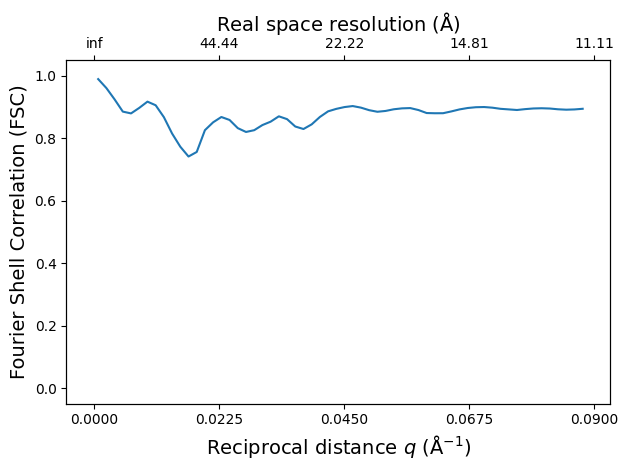

In [11]:
resolution, qshell, fsc = compute_fsc(
    spi_data['volume'].abs().pow(2) / spi_data['volume'].abs().pow(2).max(),
    real_mesh_2_reciprocal_mesh(spi_data['vol_real_mesh']), 
    intensity_pred/intensity_pred.max(),
    model.grid_position_reciprocal,
    volume_type='intensity')
display_fsc(qshell, fsc, closefig=False)

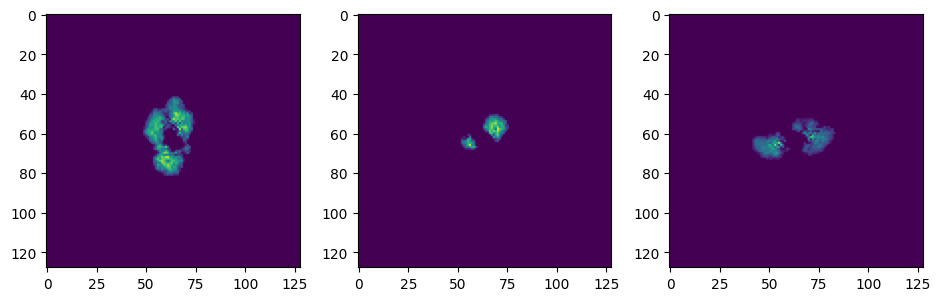

In [12]:
display_volumes(rho_phased, closefig=False, vmin=0)

In [13]:
save_mrc(f'{pdb}_pr.mrc', rho_phased.detach().cpu().numpy())

In [14]:
slice_dataset = TensorDataset(spi_data['intensities'].unsqueeze(1))
quat_dataset = TensorDataset(spi_data['orientations'])

train_idx, val_test_idx = train_test_split(np.arange(len(slice_dataset)), test_size=1/10, random_state=42)
val_idx, test_idx = train_test_split(val_test_idx, test_size=1/2, random_state=42)

train_slice_loader = DataLoader([slice_dataset[i] for i in train_idx], batch_size=100, shuffle=False)
train_quat_loader = DataLoader([quat_dataset[i] for i in train_idx], batch_size=100, shuffle=False)

val_slice_loader = DataLoader([slice_dataset[i] for i in val_idx], batch_size=100, shuffle=False)

test_slice_loader = DataLoader([slice_dataset[i] for i in test_idx], batch_size=100, shuffle=False)
test_quat_loader = DataLoader([quat_dataset[i] for i in test_idx], batch_size=100, shuffle=False)

In [15]:
orientations = []
true_matrix = []
with torch.no_grad():
    for (batch_slice, batch_quat) in zip(train_slice_loader, train_quat_loader):
        _orientations, slices_pred = model(batch_slice[0].to(device), return_reconstruction=True)
        orientations.append(_orientations.detach().cpu())
        true_matrix.append(quaternion_to_matrix(batch_quat[0].to(device)).detach().cpu())
orientations = torch.cat(orientations)
true_matrix = torch.cat(true_matrix)        

In [16]:
orientations.shape

torch.Size([9000, 3, 3])

In [59]:
_rotmat_pred1, _ae = align_rotation_matrices(orientations[8628,None], true_matrix[8628,None], n_search=1000)
print(_rotmat_pred1, _ae)

100%|██████████| 9/9 [00:02<00:00,  3.19it/s]

tensor([[ 0.5219, -0.8524, -0.0321],
        [ 0.2371,  0.1812, -0.9544],
        [ 0.8194,  0.4905,  0.2967]]) tensor(0.0071)


In [60]:
_rotmat_pred2, _ae = align_rotation_matrices(orientations[11:12], true_matrix[11:12], n_search=1000)
print(_rotmat_pred2, _ae)

100%|██████████| 9/9 [00:02<00:00,  3.20it/s]

tensor([[ 0.9442, -0.0833,  0.3187],
        [ 0.1500, -0.7525, -0.6413],
        [ 0.2932,  0.6533, -0.6980]]) tensor(0.0071)


In [62]:
so3_relative_angle(_rotmat_pred1[None], _rotmat_pred2[None])

tensor([1.3600])

In [30]:
so3_relative_angle(orientations, orientations)

tensor([0.0071, 0.0071, 0.0071,  ..., 0.0071, 0.0071, 0.0071])

In [27]:
torch.arccos((torch.einsum("lij,lij->l", orientations, orientations) - 1) / 2)

tensor([   nan, 0.0005, 0.0000,  ..., 0.0005,    nan, 0.0007])

In [26]:
torch.arccos((torch.einsum("lij,lij->l", _rotmat_pred1[None], _rotmat_pred1[None]) - 1) / 2)

tensor([0.])

In [71]:
so3_rotation_angle(torch.einsum("lij, lkj -> lik", orientations, true_matrix)[8628,None])

tensor([1.5708])

In [54]:
rel_angle = so3_rotation_angle(torch.einsum("lij, lkj -> lik", orientations, true_matrix), cos_bound=1e-6)

In [55]:
rel_angle = torch.where(rel_angle > np.pi/2, np.pi - rel_angle, rel_angle)

In [57]:
rel_angle.argmax()

tensor(8628)

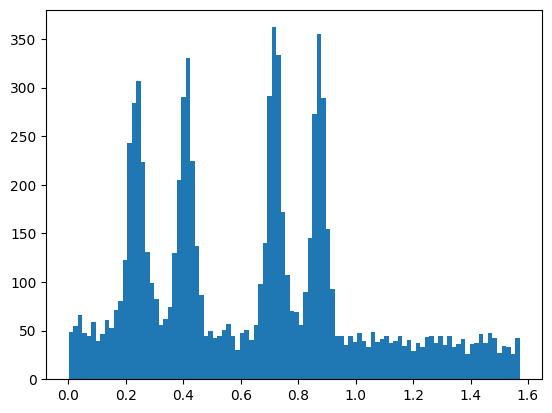

In [56]:
plt.hist(rel_angle, bins=100);

In [72]:
from pymatgen.symmetry.groups import PointGroup

In [75]:
pt_group = PointGroup('2/m')

In [89]:
symm_op_list = [symm_op.rotation_matrix for symm_op in pt_group.symmetry_ops]

In [99]:
symm_op_list

[array([[ 1.,  0.,  0.],
        [ 0., -1.,  0.],
        [ 0.,  0.,  1.]]),
 array([[-1.,  0.,  0.],
        [ 0., -1.,  0.],
        [ 0.,  0., -1.]]),
 array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]),
 array([[-1.,  0.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  0., -1.]])]

In [111]:
rel_angle = []
for _symm_op in symm_op_list[2:]:
    symm_oped_true_matrix = torch.einsum("lij, jk -> lik", true_matrix, torch.from_numpy(_symm_op).to(true_matrix))
    rel_angle.append(so3_rotation_angle(torch.einsum("lij, lkj -> lik", orientations, symm_oped_true_matrix), cos_bound=1e-6))
rel_angle = torch.vstack(rel_angle)
rel_angle = torch.where(rel_angle > np.pi/2, np.pi - rel_angle, rel_angle).min(dim=0).values

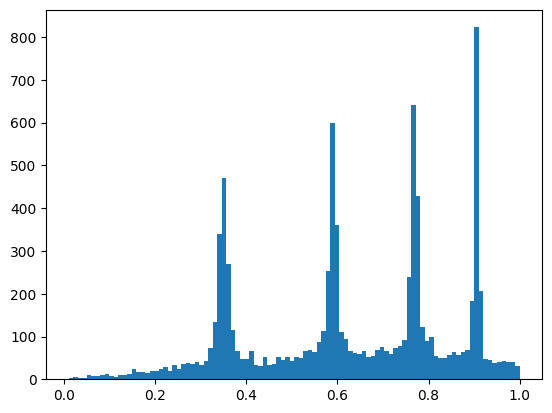

In [120]:
rel_angle = []
scalar_prod = []
for _symm_op in symm_op_list[2:]:
    symm_oped_true_matrix = torch.einsum("lij, jk -> lik", true_matrix, torch.from_numpy(_symm_op).to(true_matrix))
    scalar_prod.append(torch.einsum("li, li -> l", matrix_to_quaternion(orientations), matrix_to_quaternion(symm_oped_true_matrix)))
    scalar_prod.append(torch.einsum("li, li -> l", -matrix_to_quaternion(orientations), matrix_to_quaternion(symm_oped_true_matrix)))
scalar_prod = torch.vstack(scalar_prod).max(dim=0).values
plt.hist(scalar_prod, bins=100);

In [126]:
(torch.arccos(torch.tensor(0.5)) * 2)

tensor(2.0944)

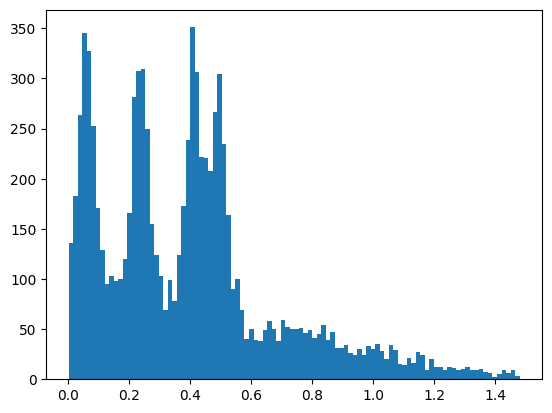

In [112]:
plt.hist(rel_angle, bins=100);

In [106]:
rotmat = torch.randn(4).to(device)
rotmat /= rotmat.norm()
rotmat = quaternion_to_matrix(rotmat)
rotmat.requires_grad = True

rotmat_opt = torch.optim.Adam([rotmat], lr=0.1)

In [107]:
loss_hist = []

for i in range(100):
    rot_orientations = torch.einsum("ij, njk -> nik", rotmat, orientations)
    loss = so3_relative_angle(rot_orientations, true_matrix).mean()

    rotmat_opt.zero_grad()
    loss.backward()
    rotmat_opt.step()

    loss_hist.append(loss.item())

    # Re-projecting rotmat onto SO(3) using SVD
    # Provided by OpenAI's ChatGPT GPT-4 model
    # See https://en.wikipedia.org/wiki/Orthogonal_Procrustes_problem
    with torch.no_grad():
        U, _, V = torch.linalg.svd(rotmat)
        rotmat[:] = U @ V.transpose(-2, -1)

        # Optional: Ensure determinant is 1 (i.e., it's a proper rotation and not a reflection)
        if torch.det(rotmat) < 0:
            U[:, :, -1] = -U[:, :, -1]
            rotmat[:] = U @ V.transpose(-2, -1)